In [1]:
########################################################
# this imports all the functions in logistic regression
# you should be able to run this cell at any time to 
# "reload" the functions
########################################################

from logistic_regression import *

In [2]:
########################################################
# prepare and load the training data.  this involves
# reading in the data and finding the best features
########################################################

# if cant find stopwords you can download using this:
# import nltk
# nltk.download('stopwords')

# init
stop_words = stopwords.words('english')
train_data = 'train.csv'
# test_data = 'test.csv'

# interpret data
messages, text_labels = read_spam_data(train_data)
all_train_data = create_train_data(messages, stop_words)
int_labels = create_spam_ham_labels(text_labels, spam=1, ham=0)

# get sizes
n_messages = len(messages)
n_features = all_train_data.shape[1]

# make sure everything is still aligned
print(all_train_data.shape)
assert all_train_data.shape[0] == len(messages)
assert all_train_data.shape[0] == len(int_labels)
assert all_train_data.shape[0] == len(text_labels)

(3000, 6179)


In [3]:
########################################################
# this is the definition of the hyper parameters for
# the regression
########################################################

# lambda
lambda_base = 2 #8 #np.e
lambda_exp_min = -18 #-5
lambda_exp_max = 3 #1
list_of_lambdas = [lambda_base**i for i in range(lambda_exp_min,lambda_exp_max+1)] 
print("LAMBDAS:\n\tbase: {}   log_min: {}   log_max: {}\n\t{}".format( 
      lambda_base, lambda_exp_min, lambda_exp_max, list_of_lambdas))

# sigmoid params
eta_0 = 0.1
alpha = 0.9

LAMBDAS:
	base: 2   log_min: -18   log_max: 3
	[3.814697265625e-06, 7.62939453125e-06, 1.52587890625e-05, 3.0517578125e-05, 6.103515625e-05, 0.0001220703125, 0.000244140625, 0.00048828125, 0.0009765625, 0.001953125, 0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]


In [4]:
########################################################
# divide the data for 10-fold cross validation
########################################################

# identifiers
TRAIN_DATA = "t_data"
TRAIN_LABELS = "t_labels"
VALIDATE_DATA = "v_data"
VALIDATE_LABELS = "v_labels"

# prep
number_of_buckets = 10
size_of_bucket = int(n_messages / number_of_buckets)
all_train_buckets = dict()

# divide into buckets
idx = 0
for b in range(number_of_buckets):
    data = all_train_data[idx:idx+size_of_bucket]
    labels = int_labels[idx:idx+size_of_bucket]
    all_train_buckets[b] = [data, labels]
    idx += size_of_bucket
    
    
# how to create train and validation data sets
def get_train_data_set(idx):
    t_data, t_labels = list(), list()
    v_data, v_labels = None, None
    for k in all_train_buckets.keys():
        v = all_train_buckets[k]
        if k == idx:
            v_data = v[0]
            v_labels = v[1]
        else:
            t_data.append(v[0])
            t_labels.append(v[1])
    return {
        TRAIN_DATA: np.vstack(t_data), 
        TRAIN_LABELS: np.hstack(t_labels),  
        VALIDATE_DATA: v_data, 
        VALIDATE_LABELS: v_labels
    }

# get data
all_training_datasets = [get_train_data_set(x) for x in list(range(number_of_buckets))]

# validation
assert len(all_training_datasets) == number_of_buckets
for ds in all_training_datasets:
    assert ds[TRAIN_DATA].shape[1] == n_features
    assert ds[TRAIN_DATA].shape[0] == len(ds[TRAIN_LABELS])
    assert ds[VALIDATE_DATA].shape[1] == n_features
    assert ds[VALIDATE_DATA].shape[0] == len(ds[VALIDATE_LABELS])

In [5]:
########################################################
# definition of our regression function
########################################################


def run_regression(lamda, train, train_labels, validate, validate_labels, 
                   eta_0=0.1, alpha=0.9, iterations=321, verbose=False):
    # init
    report_frequency = int(iterations / 16.0)
    t = None
    
    #run regression
    try:
        weights = np.random.normal(0, 0.2, n_features)
        min_validate_loss = sys.maxsize
        min_train_loss = sys.maxsize
        for t in range(iterations):
            weights = logistic_regression(train, train_labels, weights, lamda, alpha, eta_0, t)
            train_loss = square_loss(train, train_labels, weights=weights)
            val_loss = square_loss(validate, validate_labels, weights=weights)
            if verbose and t % report_frequency == 0:
                print("{}:\t#{}\ttrain {}  \t\tvalidate {}".format(l, t, train_loss, val_loss))
            if val_loss < min_validate_loss: min_validate_loss = val_loss
            if train_loss < min_train_loss: min_train_loss = train_loss
    except Exception as e:
        print("\nlambda {} #{}: {}".format(l, t, e), sys.stderr)
        import traceback
        traceback.print_exc()
        return False
    
    # return best
    return min_validate_loss, min_train_loss

In [6]:
########################################################
# run on each of our k-folded datasets
########################################################

# prep
lambda_to_validate_errors = dict()
lambda_to_training_errors = dict()

# calculate for our lambdas
for l in list_of_lambdas:
    start = timer()
    print("\nLAMBDA: {}\n\t".format(l),end='')
    v_errors = list()
    t_errors = list()
    lambda_to_validate_errors[l] = v_errors
    lambda_to_training_errors[l] = t_errors
    for dataset in all_training_datasets:
        v_error, t_error = run_regression(l, dataset[TRAIN_DATA], dataset[TRAIN_LABELS], 
                       dataset[VALIDATE_DATA], dataset[VALIDATE_LABELS])
        v_errors.append(v_error)
        t_errors.append(t_error)
        print('.', end='')
    print(" ({}s)".format(int(timer() - start)))
    print("\tv errors:    {}".format(v_errors))
    print("\tv error avg: {}".format(np.mean(v_errors)))
    print("\tv error std: {}".format(np.std(v_errors)))


LAMBDA: 3.814697265625e-06
	.......... (229s)
	v errors:    [3.5647690661476017, 5.133366933702785, 4.638260301316997, 4.42305240315012, 5.178125305910893, 4.855358925247892, 3.0020119501703113, 3.394440442991451, 3.236079378458119, 2.709137728010357]
	v error avg: 4.013460243510653
	v error std: 0.882648577411582

LAMBDA: 7.62939453125e-06
	.......... (227s)
	v errors:    [3.585546504000259, 5.371451538300512, 4.776087948329062, 4.382563998922925, 5.044300923684652, 4.999338961851623, 2.9361191337703416, 3.441897570871343, 3.166339721065919, 2.756380866783787]
	v error avg: 4.046002716758042
	v error std: 0.9248944722270547

LAMBDA: 1.52587890625e-05
	.......... (229s)
	v errors:    [3.6411084466154615, 5.393276826301738, 4.65297205093758, 4.473483858463125, 5.0948939265882585, 4.886159765545371, 3.0469279707642256, 3.4525310343571416, 3.273920714169579, 2.6838991003385857]
	v error avg: 4.059917369408106
	v error std: 0.9020052728764745

LAMBDA: 3.0517578125e-05
	.......... (226s)
	

D:\ucsc_projects\classes\cmps242\hw2\cmpshw3\logistic_regression.py:140: RuntimeWarning: overflow encountered in multiply
  new_weights = weights*(1-(eta*l)) - (eta*np.matmul(np.array(y_hat-labels), inputs))


.......... (229s)
	v errors:    [14.88604954231149, 14.510717431216971, 13.597560149389, 13.312495047096471, 14.025759953415577, 13.985770559972487, 13.172968682499796, 13.317558846048437, 13.574784611179288, 12.498583369679718]
	v error avg: 13.688224819280922
	v error std: 0.6552962804770385

LAMBDA: 4
	.......... (226s)
	v errors:    [18.86795862535735, 18.269875363494254, 17.70847992783336, 17.313904045697306, 17.822863362888363, 17.86179394946371, 16.281856929305214, 17.048225218866065, 17.461189722964676, 16.184818455686056]
	v error avg: 17.482096560155632
	v error std: 0.7869705501199931

LAMBDA: 8
	.......... (229s)
	v errors:    [20.603910986226968, 19.614282909690818, 17.88377771839103, 17.691438305008006, 19.617748944800663, 18.930858248160874, 16.986887460294692, 18.83498870013509, 19.86892202089999, 16.0]
	v error avg: 18.603281529360814
	v error std: 1.3621884976989045


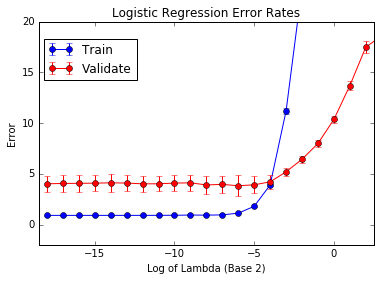

In [9]:
########################################################
# analyze and print plots of the data
########################################################
# %matplotlib inline
import matplotlib.pyplot as plt

def get_plot_data(items):
    items.sort(key=lambda x: x[0])
    x, y, var, log_lambda = list(), list(), list(), lambda_exp_min
    for k, v in items:
        x.append(log_lambda)
        y.append(np.mean(v))
        var.append(np.std(v)**2)
        assert lambda_base**log_lambda == k
        log_lambda += 1
    return x, y, var

validate_x, validate_y, validate_v = get_plot_data(list(lambda_to_validate_errors.items()))
train_x, train_y, train_v = get_plot_data(list(lambda_to_training_errors.items()))

plt.errorbar(train_x, train_y, train_v, None, 'bo-', label="Train")
plt.errorbar(validate_x, validate_y, validate_v, None, 'ro-', label="Validate")
plt.axis([lambda_exp_min-.5, lambda_exp_max-.5, -2, 20])
plt.legend(bbox_to_anchor=(.31,.95))
plt.title("Logistic Regression Error Rates")
plt.xlabel("Log of Lambda (Base {})".format(lambda_base))
plt.ylabel("Error")

plt.show()